In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from PIL import Image

In [3]:
import numpy as np

In [4]:
import os
from glob import glob

In [5]:
import shutil

In [6]:
import sys

In [7]:
import torch

In [8]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
def get_image_paths(data_path, categories, num_train_per_cat):
    num_categories = len(categories)

    train_image_paths = []
    test_image_paths = []
    validation_image_paths = []
    
    train_labels = []
    test_labels = []
    validation_labels = []

    for category in categories:
        
        image_paths = glob(os.path.join(data_path, 'train', category, '*.jpg'))
        train_len = len(image_paths)
        #print(train_len)
        for i in range(train_len):
            train_image_paths.append(image_paths[i])
            train_labels.append(category)

        image_paths = glob(os.path.join(data_path, 'test', category, '*.jpg'))
        test_len = len(image_paths)
        #print(test_len)
        for i in range(test_len):
            test_image_paths.append(image_paths[i])
            test_labels.append(category)
            
        image_paths = glob(os.path.join(data_path, 'validation', category, '*.jpg'))
        validation_len = len(image_paths)
        #print(validation_len)
        for i in range(validation_len):
            validation_image_paths.append(image_paths[i])
            validation_labels.append(category)
        
    return train_image_paths, test_image_paths, validation_image_paths, train_labels, test_labels, validation_labels

In [11]:
DATA_PATH = 'C:\\Users\\white power\\Desktop\\New Folder (6)\\SceneDataset\\'

In [12]:
train_dir = 'C:\\Users\\white power\\Desktop\\New Folder (6)\\SceneDataset\\train'
test_dir = 'C:\\Users\\white power\\Desktop\\New Folder (6)\\SceneDataset\\test'
validation_dir = 'C:\\Users\\white power\\Desktop\\New Folder (6)\\SceneDataset\\validation'

In [13]:
train_dataset = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((32,32)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((32,32)),transforms.ToTensor()
]))
validation_dataset = ImageFolder(validation_dir,transforms.Compose([
    transforms.Resize((32,32)),transforms.ToTensor()
]))

In [14]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 32, 32]) 0


In [15]:
print("Follwing classes are there : \n",train_dataset.classes)

Follwing classes are there : 
 ['airport_inside', 'artstudio', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'church_inside', 'classroom', 'closet', 'clothingstore', 'computerroom']


Label : airport_inside


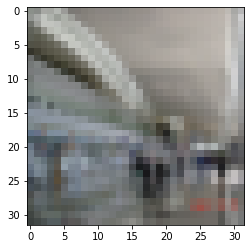

In [16]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[0])

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size = 16

print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(validation_dataset)}")

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(validation_dataset, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 2689
Length of Validation Data : 900


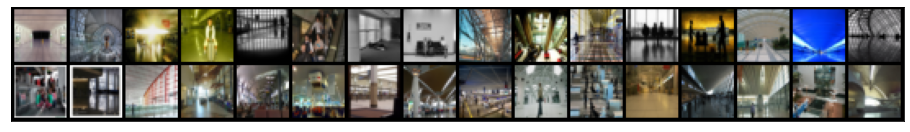

In [18]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(val_dl)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
class SceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 4, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(4,4, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(4, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16 ,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,15)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [21]:
# For updating learning rate
def update_lrn(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    curr_lr = lr
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Decay learning rate
        if (epoch+1) % 20 == 0:
            curr_lr /= 3
            update_lrn(optimizer, curr_lr)
    return history

In [23]:
num_epochs = 0
opt_func = torch.optim.Adam
lr = 0.002
model = SceneClassification()
if torch.cuda.is_available():
    model.cuda()

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


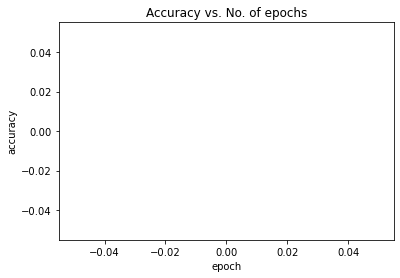

In [24]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

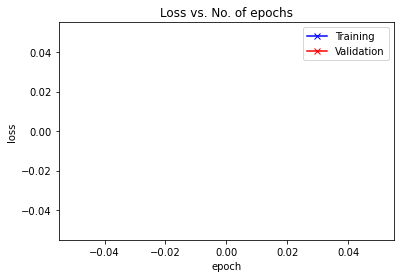

In [25]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [26]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [27]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = conv3x3(out_channels, out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv4 = conv3x3(out_channels, out_channels)
        self.bn4 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv5 = conv3x3(out_channels, out_channels)
        self.bn5 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.bn5(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [28]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=15):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[0])
        self.layer3 = self.make_layer(block, 32, layers[0])
        self.layer4 = self.make_layer(block, 32, layers[1], 2)
        self.layer5 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, 16)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.3) 

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        #out = self.fc(out)
        out = self.dropout(self.fc(out))
        #out = self.fc2(out)
        out = self.dropout(self.fc2(out))
        return out

In [29]:
learning_rate = 0.002

In [30]:
model = ResNet(ResidualBlock, [2, 2, 2]).cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [32]:
# Train the model
total_step = len(train_dl)
curr_lr = learning_rate
num_epochs = 0
train_losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):
        images, labels = images.cuda(), labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_losses.append(loss)
        
        
        
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 2
        update_lr(optimizer, curr_lr)

In [33]:
#Test the model
model.eval()
accuracy = []
test_predicts = []
test_labelss = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy.append(correct / total)
        for x in predicted:
            test_predicts.append(x.item())
        for y in labels:
            test_labelss.append(y.item())
        
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 3.0201342281879193 %


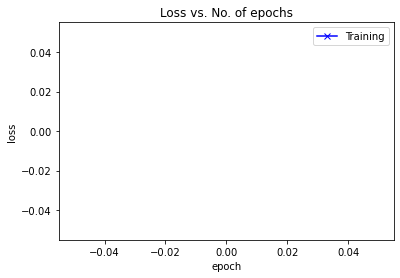

In [34]:
def plot_loss(train_losses):
    """ Plot the losses in each epoch"""
    #train_losses = [x.get('train_loss') for x in train_losses]
    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training'])
    plt.title('Loss vs. No. of epochs');

plot_loss(train_losses)

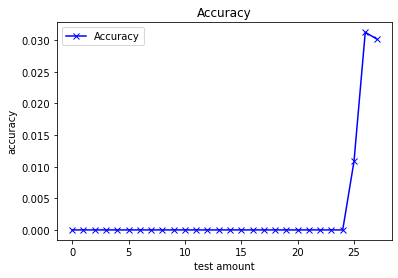

In [35]:
def plot_accuracy(accuracy):
    """ Plot the losses in each epoch"""
    #train_losses = [x.get('accuracy') for x in history]
    plt.plot(accuracy, '-bx')
    plt.xlabel('test amount')
    plt.ylabel('accuracy')
    plt.legend(['Accuracy'])
    plt.title('Accuracy');

plot_accuracy(accuracy)

In [36]:
def plot_confusion_matrix(cm, category, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category))
    plt.xticks(tick_marks, category, rotation=45)
    plt.yticks(tick_marks, category)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
def build_confusion_mtx(test_labels_ids, predicted_categories, abbr_categories):

    cm = confusion_matrix(test_labels_ids, predicted_categories)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_normalized, abbr_categories, title='Normalized confusion matrix')

    plt.show()

In [38]:
CATEGORIES = ['airport_inside', 'artstudio', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'church_inside', 'classroom', 'closet', 'clothingstore', 'computerroom']

In [39]:
ABBR_CATEGORIES = ['Air', 'Art', 'Bak', 'Bar', 'Bat', 'Bed', 'Bok', 'Bow', 'Buf', 'Cas', 'Chu', 'Cla', 'Cls', 'Clt', 'Com']

In [40]:
NUM_TRAIN_PER_CAT = 100

In [41]:
CATE2ID = {v: k for k, v in enumerate(CATEGORIES)}

In [42]:
train_image_paths, test_image_paths, validation_image_paths, train_labels, test_labels, validation_labels = get_image_paths(DATA_PATH, CATEGORIES, NUM_TRAIN_PER_CAT)

In [43]:
print(test_labelss[0])
print("-----------")
print(test_predicts[0])

0
-----------
12


In [44]:
#test_labels_ids = [CATE2ID[x] for x in test_labelss]
#predicted_categories_ids = [CATE2ID[x] for x in test_predicts]

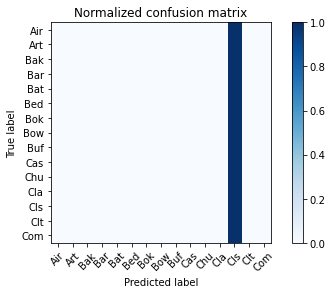

In [45]:
build_confusion_mtx(test_labelss, test_predicts, ABBR_CATEGORIES)

In [46]:
from __future__ import print_function
from __future__ import division

In [47]:
import torch.nn as nn
import torch.optim as optim

In [48]:
from torchvision import datasets, models, transforms

In [49]:
import matplotlib.pyplot as plt
import time
import os
import copy

In [50]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1
Torchvision Version:  0.9.1


In [51]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#path = DATA_PATH

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 15

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [53]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [54]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # make only the fc layer learnable

In [55]:
train_dataset = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))
validation_dataset = ImageFolder(validation_dir,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

In [56]:
from torch.utils.data.dataloader import DataLoader

print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(validation_dataset)}")

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(validation_dataset, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 2689
Length of Validation Data : 900


In [57]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [58]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x]) for x in ['train', 'validation']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

Initializing Datasets and Dataloaders...


In [60]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [61]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [62]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/99
----------
train Loss: 1.6408 Acc: 0.5091
validation Loss: 0.8662 Acc: 0.7278

Epoch 1/99
----------
train Loss: 1.1034 Acc: 0.6594
validation Loss: 0.6305 Acc: 0.7822

Epoch 2/99
----------
train Loss: 0.9314 Acc: 0.7144
validation Loss: 0.6593 Acc: 0.7811

Epoch 3/99
----------
train Loss: 0.8374 Acc: 0.7382
validation Loss: 0.5589 Acc: 0.8033

Epoch 4/99
----------
train Loss: 0.8339 Acc: 0.7397
validation Loss: 0.5144 Acc: 0.8411

Epoch 5/99
----------
train Loss: 0.8030 Acc: 0.7445
validation Loss: 0.5021 Acc: 0.8400

Epoch 6/99
----------
train Loss: 0.7598 Acc: 0.7538
validation Loss: 0.4891 Acc: 0.8389

Epoch 7/99
----------
train Loss: 0.7490 Acc: 0.7646
validation Loss: 0.5491 Acc: 0.8089

Epoch 8/99
----------
train Loss: 0.7597 Acc: 0.7438
validation Loss: 0.4610 Acc: 0.8489

Epoch 9/99
----------
train Loss: 0.7616 Acc: 0.7553
validation Loss: 0.4584 Acc: 0.8456

Epoch 10/99
----------
train Loss: 0.7267 Acc: 0.7612
validation Loss: 0.4548 Acc: 0.8433

Epoch 11/

train Loss: 0.6075 Acc: 0.8007
validation Loss: 0.3967 Acc: 0.8756

Epoch 91/99
----------
train Loss: 0.5867 Acc: 0.8144
validation Loss: 0.4860 Acc: 0.8389

Epoch 92/99
----------
train Loss: 0.5987 Acc: 0.7984
validation Loss: 0.4302 Acc: 0.8656

Epoch 93/99
----------
train Loss: 0.6365 Acc: 0.7921
validation Loss: 0.4900 Acc: 0.8411

Epoch 94/99
----------
train Loss: 0.5917 Acc: 0.8044
validation Loss: 0.4719 Acc: 0.8544

Epoch 95/99
----------
train Loss: 0.5722 Acc: 0.8133
validation Loss: 0.4514 Acc: 0.8522

Epoch 96/99
----------
train Loss: 0.6019 Acc: 0.7925
validation Loss: 0.4497 Acc: 0.8633

Epoch 97/99
----------
train Loss: 0.5993 Acc: 0.8070
validation Loss: 0.4173 Acc: 0.8578

Epoch 98/99
----------
train Loss: 0.6150 Acc: 0.8051
validation Loss: 0.4210 Acc: 0.8700

Epoch 99/99
----------
train Loss: 0.5979 Acc: 0.8036
validation Loss: 0.3976 Acc: 0.8656

Training complete in 28m 22s
Best val Acc: 0.880000


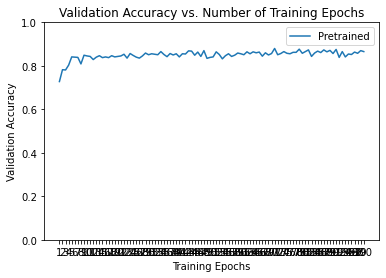

In [63]:
ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [64]:
#Test the model
model_ft.eval()
accuracy = []
test_predicts = []
test_labelss = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy.append(correct / total)
        for x in predicted:
            test_predicts.append(x.item())
        for y in labels:
            test_labelss.append(y.item())
        
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 83.668903803132 %


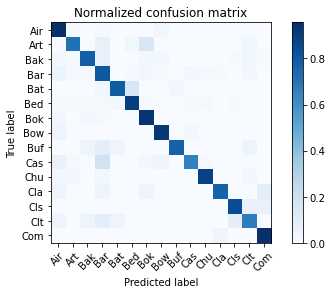

In [65]:
build_confusion_mtx(test_labelss, test_predicts, ABBR_CATEGORIES)

In [66]:
def set_parameter_requires_grad2(model):
    child_counter = 0
    for child in model.children():
        if child_counter < 7:
            print("child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        elif child_counter == 7:
                print("child ",child_counter," was not frozen")
        elif child_counter == 8:
            print("child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        else:
            print("child ",child_counter," was not frozen")
        child_counter += 1

In [67]:
def initialize_model2(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad2(model_ft)

        model_ft.layer4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                                        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                                        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [68]:
# Initialize the model for this run
model_ft2, input_size = initialize_model2(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft2)

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was frozen
child  6  was frozen
child  7  was not frozen
child  8  was frozen
child  9  was not frozen
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
   

In [69]:
# Send the model to GPU
model_ft2 = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft2 = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [70]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft2, hist = train_model(model_ft2, dataloaders_dict, criterion, optimizer_ft2, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/99
----------
train Loss: 0.6161 Acc: 0.7903
validation Loss: 0.4574 Acc: 0.8478

Epoch 1/99
----------
train Loss: 0.5833 Acc: 0.8107
validation Loss: 0.4403 Acc: 0.8600

Epoch 2/99
----------
train Loss: 0.6762 Acc: 0.7847
validation Loss: 0.4780 Acc: 0.8422

Epoch 3/99
----------
train Loss: 0.6296 Acc: 0.8007
validation Loss: 0.4207 Acc: 0.8622

Epoch 4/99
----------
train Loss: 0.6177 Acc: 0.7973
validation Loss: 0.4605 Acc: 0.8533

Epoch 5/99
----------
train Loss: 0.6178 Acc: 0.7929
validation Loss: 0.4186 Acc: 0.8622

Epoch 6/99
----------
train Loss: 0.5856 Acc: 0.8014
validation Loss: 0.4749 Acc: 0.8478

Epoch 7/99
----------
train Loss: 0.5854 Acc: 0.8137
validation Loss: 0.4371 Acc: 0.8511

Epoch 8/99
----------
train Loss: 0.6213 Acc: 0.8007
validation Loss: 0.4094 Acc: 0.8611

Epoch 9/99
----------
train Loss: 0.6424 Acc: 0.7988
validation Loss: 0.4090 Acc: 0.8622

Epoch 10/99
----------
train Loss: 0.5946 Acc: 0.8029
validation Loss: 0.4133 Acc: 0.8700

Epoch 11/

train Loss: 0.5799 Acc: 0.8115
validation Loss: 0.4179 Acc: 0.8611

Epoch 91/99
----------
train Loss: 0.5702 Acc: 0.8167
validation Loss: 0.4203 Acc: 0.8622

Epoch 92/99
----------
train Loss: 0.6049 Acc: 0.8066
validation Loss: 0.4755 Acc: 0.8600

Epoch 93/99
----------
train Loss: 0.5528 Acc: 0.8196
validation Loss: 0.4810 Acc: 0.8456

Epoch 94/99
----------
train Loss: 0.5839 Acc: 0.8174
validation Loss: 0.4546 Acc: 0.8578

Epoch 95/99
----------
train Loss: 0.6082 Acc: 0.8025
validation Loss: 0.4229 Acc: 0.8633

Epoch 96/99
----------
train Loss: 0.6083 Acc: 0.8029
validation Loss: 0.5027 Acc: 0.8367

Epoch 97/99
----------
train Loss: 0.5935 Acc: 0.8070
validation Loss: 0.4117 Acc: 0.8678

Epoch 98/99
----------
train Loss: 0.5821 Acc: 0.8044
validation Loss: 0.3941 Acc: 0.8800

Epoch 99/99
----------
train Loss: 0.5622 Acc: 0.8174
validation Loss: 0.4448 Acc: 0.8611

Training complete in 28m 25s
Best val Acc: 0.881111


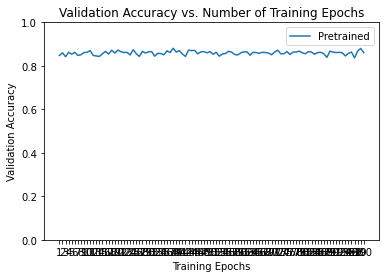

In [71]:
ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [72]:
#Test the model
model_ft2.eval()
accuracy = []
test_predicts = []
test_labelss = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy.append(correct / total)
        for x in predicted:
            test_predicts.append(x.item())
        for y in labels:
            test_labelss.append(y.item())
        
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 85.57046979865771 %


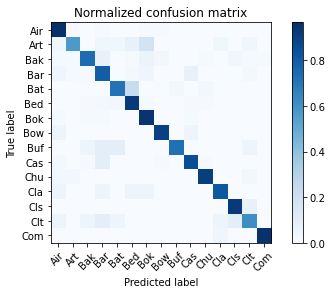

In [73]:
build_confusion_mtx(test_labelss, test_predicts, ABBR_CATEGORIES)